# Minneapolis Housing Research

In [1]:
import csv
import sqlite3
import subprocess
import os
import random
from collections import namedtuple

import numpy as np
import matplotlib.pyplot as plt

DB = sqlite3.connect('file:data/minneapolis.db?mode=ro', uri=True)

def pp(x):
    print(format (x, ',d'))

def execute(sql):
    return DB.execute(sql).fetchall()

def execute_one(sql):
    return execute(sql)[0][0]


def parse_apn(value):
    apn = value.replace('-', '')
    if len(apn) == 13:
        return apn
    elif len(apn) == 12:
        return '0' + apn
    else:
         # "Invalid APN: {} has a length of {}".format(apn, str(len(apn))))
        return None

In [2]:
print(
    subprocess.run("sqlite3 ./data/minneapolis.db '.schema'", shell=True, capture_output=True, check=True).stdout.decode('utf-8')
)

CREATE TABLE lotinfo(
  "apn" TEXT,
  "ASSESSOR_USE" TEXT,
  "TYPE" TEXT,
  "LOTSIZE" INTEGER,
  "lotDepth" INTEGER,
  "lotFrontage" TEXT,
  "PARCEL_BLOCK" TEXT,
  "PARCEL_LOT" TEXT,
  "PARCEL_ADDITION" TEXT,
  "ASSESSOR_FNAME" TEXT,
  "ASSESSOR_EXTENSION" TEXT,
  "RelativeHomestead" TEXT
);
CREATE TABLE structure_information(
  "apn" TEXT,
  "CONCAT_ADDRESS" TEXT,
  "UNIT_COUNT" INTEGER,
  "building_parkspaces" TEXT,
  "TOTAL_BEDROOMS" INTEGER,
  "TOTAL_BATHS" INTEGER,
  "BUILD_DATE" TEXT,
  "ONE_BEDROOM" TEXT,
  "TWO_BEDROOM" TEXT,
  "THREE_BEDROOM" TEXT,
  "FOUR_BEDROOM" TEXT,
  "EFFICIENCY" TEXT,
  "STORIES" INTEGER,
  "SECOND_FLOOR_AREA" INTEGER,
  "BASEMENT_AREA" INTEGER,
  "FINISHED_BASEMENT_AREA" INTEGER,
  "GROSS_BUILDING_AREA" INTEGER,
  "ABOVEGRADEAREA" INTEGER,
  "GROUND_FLOOR_AREA" INTEGER,
  "BUILDINGCODE" TEXT
);
CREATE TABLE zones(
  "apn" TEXT,
  "ZONE_CODE" TEXT,
  "ZONE_DESC" TEXT,
  "zoneType" TEXT
);
CREATE TABLE property_owner(
  "apn" TEXT,
  "OWNER_NAME" TEXT,
 

In [3]:
minneapolis = {}

for row in execute("SELECT apn, buildingcode FROM structure_information"):
    apn, bulidingcode = row
    minneapolis[apn] = { 
        "valuation_history": [], 
        "owner": None,
        "taxpayer": None,
        "sales": [],
        "buildingcode": bulidingcode
    }

Valuation = namedtuple('Valuation', ['year', 'building', 'land', 'total'])
Owner = namedtuple('Owner', ['name', 'address'])
Sale = namedtuple('Sale', ['seller', 'buyer', 'price', 'date'])
# taxpayer and buildingcode are strings


## Single Family Homes

In [4]:
single_family_homes = execute_one("SELECT COUNT(*) FROM structure_information where buildingcode = 'Single Family'")
total_lots = execute("SELECT COUNT(*) from structure_information")[0][0]

print(f"There are {single_family_homes:,} single family homes, {(float(single_family_homes)/total_lots):.0%} of all lots")

There are 75,914 single family homes, 61% of all lots


In [5]:
# valuation_history
for row in execute("SELECT apn, year, STRUCTURE_BUILDINGVALUE, STRUCTURE_LANDVALUE, STRUCTURE_TOTALVALUE FROM valuation_history ORDER BY apn ASC, year ASC"):
    apn, year, building, land, total = row
        
    if apn in minneapolis:
        minneapolis[apn]['valuation_history'].append(Valuation(year, building, land, total))

In [6]:
# property_owner
for row in execute("SELECT apn, OWNER_NAME, TRIM(OWNER_STREETADDRESS) || ' ' || TRIM(OWNER_ADDRESS) from property_owner"):
    apn, name, address = row
    
    if apn in minneapolis:
        minneapolis[apn]['owner'] = Owner(name, address)


In [7]:
# property_taxpayer
for row in execute("SELECT apn, taxpayerLine1, taxpayerLine2, taxpayerLine3, taxpayerLine4 from property_taxpayer"):
    apn, line1, line2, line3, line4 = row
        
    if apn in minneapolis:
        taxpayer = " ".join(map(lambda x: x.strip(), filter(lambda x: x, [line1, line2, line3, line4])))
        minneapolis[apn]['taxpayer'] = taxpayer
        

In [8]:
# sales
for row in execute("SELECT apn, SALES_SELLERNAME, SALES_BUYERNAME, SALES_PRICE, SALE_DATE from sale_history ORDER BY apn ASC, sale_date ASC"):
    apn, seller, buyer, price, date = row
    
    if apn in minneapolis:
       minneapolis[apn]['sales'].append(Sale(seller=seller, buyer=buyer, price=price, date=date))

In [9]:
single_family_homes = dict(filter(lambda x: x[1]['buildingcode'] == 'Single Family', minneapolis.items()))

In [10]:
# Valuation vs sale

SaleAndValue = namedtuple('SaleAndValue', ['apn', 'year', 'valuation', 'price'])

sales = []

def latest_nonzero_sale(sales):
    for sale in reversed(sales):
        if sale.price and sale.price > 0:
            return sale

def valuation_for_year(valuations, year):
   return next((v for v in valuations if v.year == year), None)
        
for apn, data in single_family_homes.items():
    sale = latest_nonzero_sale(data['sales'])
    
    if not sale:
        continue
        
    year = sale.date[0:4]
    valuation = valuation_for_year(data['valuation_history'], year)
    
    if not valuation or valuation.total == 0 or valuation.total == '':
        continue

    sales.append(SaleAndValue(apn=apn, year=year, valuation=valuation.total, price=sale.price))

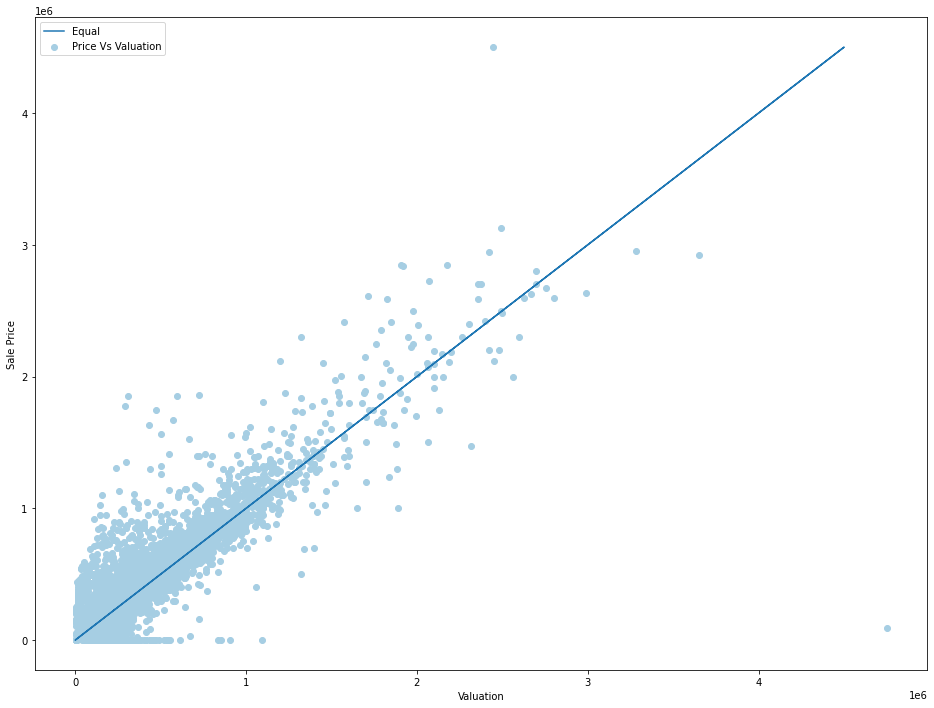

In [11]:
prices = np.array([ x.price for x in sales])
valuations = np.array([ x.valuation for x in sales])

fig, ax = plt.subplots(figsize=(16,12))
ax.scatter(valuations, prices, label="Price Vs Valuation", c='#a6cee3')
ax.plot(prices, prices, label="Equal")
ax.set_ylabel('Sale Price')
ax.set_xlabel('Valuation')
ax.legend()


## Profile Of A Flipped Property

## Sales and Valuation

## Permits

In [12]:
# unique permits
pp(execute("SELECT count(distinct pid) from permit_details")[0][0])

828,974


## Downtown Properties CSV

In [20]:
added_fieldnames = [
    'owner_name', 'owner_address', 'taxpayer', 'buildingcode', 
    'valuation_total_2010', 'valuation_total_2015', 'valuation_total_2018', 'valuation_total_2019',
    'valuation_building_2010', 'valuation_building_2015', 'valuation_building_2018', 'valuation_building_2019',
    'valuation_land_2010', 'valuation_land_2015', 'valuation_land_2018', 'valuation_land_2019',
    'sales0_date', 'sales0_seller', 'sales0_buyer', 'sales0_price',
    'sales1_date', 'sales1_seller', 'sales1_buyer', 'sales1_price'
]

def add_fields_from_database_to_csv(row, apn_field='pid'):
    for field in added_fieldnames:
        row[field] = None
 
    apn = parse_apn(row[apn_field].strip())
    
    if not apn or apn not in minneapolis:
        return
    
    property = minneapolis[apn]

    row['buildingcode'] = property['buildingcode']
    row['taxpayer'] = property['taxpayer']
    
    if property['valuation_history']:
        for year in ['2010', '2015', '2018', '2019']:
            valuation = valuation_for_year(property['valuation_history'], year)
            if valuation:
              for valuation_type in ['land', 'building', 'total']:
                row[f"valuation_{valuation_type}_{year}"] = getattr(valuation, valuation_type)

    if property['owner']:
        row['owner_name'] = minneapolis[apn]['owner'].name
        row['owner_address'] = minneapolis[apn]['owner'].address

    for i, sale in enumerate(property['sales'][-2:]):
        row[f"sales{i}_date"] = sale.date
        row[f"sales{i}_seller"] = sale.seller
        row[f"sales{i}_buyer"] = sale.buyer
        row[f"sales{i}_price"] = sale.price


In [21]:
with open('./data/dt_properties.csv', 'r') as dt_properties_in:
    with open('./data/dt_properties_out.csv', 'w') as dt_properties_out:
        reader = csv.DictReader(dt_properties_in)
        writer = csv.writer(dt_properties_out)
        
        writer.writerow(reader.fieldnames + added_fieldnames)
        
        for row in reader:
            add_fields_from_database_to_csv(row, apn_field='PID')               
            writer.writerow(row.values())
    
    

In [22]:
with open('./data/damaged.csv', 'r') as infile:
    with open('./data/damaged_out.csv', 'w') as outfile:
        reader = csv.DictReader(infile)
        writer = csv.writer(outfile)
        
        writer.writerow(reader.fieldnames + added_fieldnames)
        
        for row in reader:
            add_fields_from_database_to_csv(row)            
            writer.writerow(row.values())
                                
    